In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import numpy.polynomial.legendre as legendre

from genquad import *
from testproblems import *
from functionfamiliy import *

Generate test example

In [2]:
eps_disc = 1e-8
eps_comp = 1e2*eps_disc
eps_quad = None
I = Interval(1e-6,1)
F = example_problem(I, number_of_functions = 10, expr_gen=gen_poly_and_sing)
ex_f, ex_f_expr = F.generate_example_function()
ex_f_expr

0.130607785692701/x**1.09872827848499 - 0.443089912631503*x**4 - 0.157629761423002*x**3 - 0.0164497411349369*x**2 - 0.984540623001078*x + 0.622442441985585

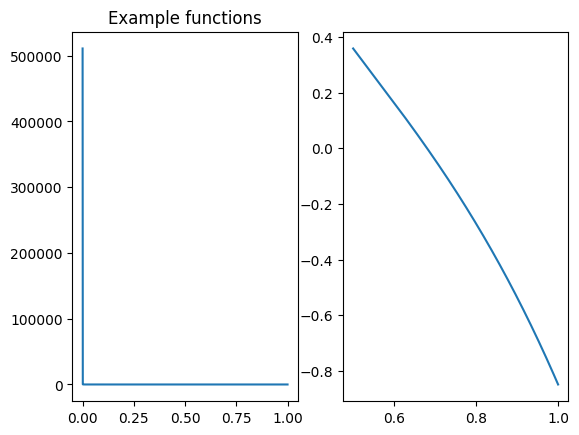

In [3]:
plt.figure("Example function")
xx = np.linspace(I.a,I.b,1000)
functions_to_plot = 5
plt.subplot(1, 2, 1)
plt.title("Example functions")
plt.plot(xx,ex_f(xx))
plt.subplot(1, 2, 2)
xx2 = np.linspace((I.a+I.b)/2,I.b,1000)
plt.plot(xx2,ex_f(xx2))

Discretize and compress

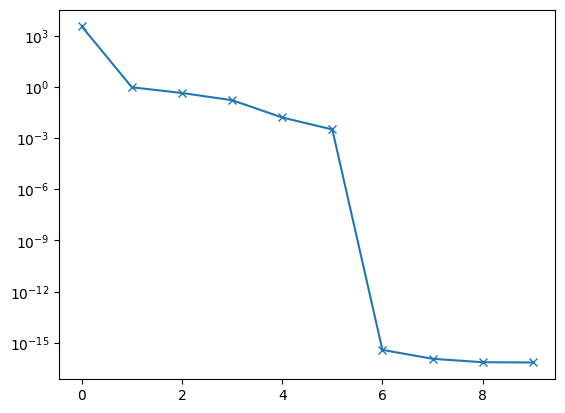

In [4]:
x, w, endpoints = adaptive_discretization(F, precision=eps_disc, k=30, verbose=False)
U, A, rank = compress_sequence_of_functions(F, x, w, precision=eps_comp)
Q,R,perm = sp.linalg.qr(A, pivoting = True)
plt.semilogy(np.abs(np.diag(R)),"-x")

(1e-06, 1.0)

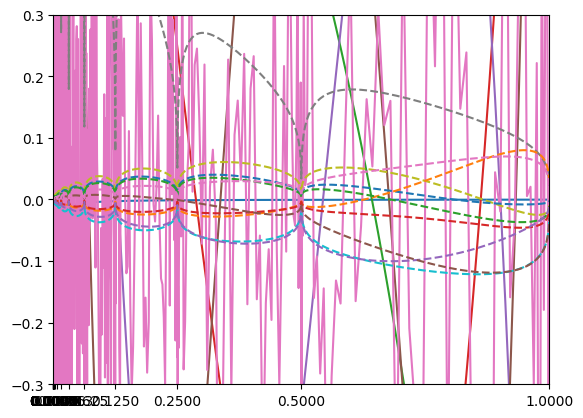

In [5]:
plt.figure();
plt.xticks(endpoints);
plt.plot(x,U);
plt.plot(x,A,"--");
plt.ylim(-0.3,0.3)
plt.xlim(I.a,I.b)

Chebyshev

In [6]:
r = U.T@w
k = len(r)

B = np.sqrt(w)*U.T
Q,R,perm = sp.linalg.qr(B, pivoting=True)
z = np.linalg.solve(R[:k,:k], Q.T@r) ## No Hermetian transpose in python? For now only support real functions.

idx = perm[:k]
x_cheb = x[idx]
w_cheb = z*np.sqrt(w[idx])

Example function integration test

3.84860429759167 3.8486042975916894 3.848604297591656


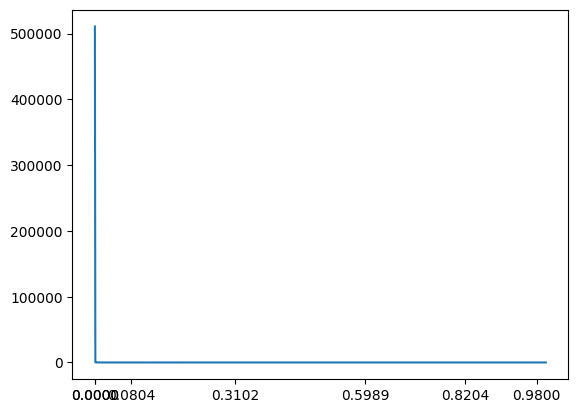

In [7]:
plt.plot(xx,ex_f(xx));
plt.xticks(x_cheb)
print(F.target_integral(ex_f_expr), ex_f(x)@w, ex_f(x_cheb)@w_cheb)

Point comparison

[0.025 0.129 0.297 0.5   0.703 0.871 0.975]
[1.000000e-06 9.800196e-01 8.204309e-01 1.300000e-06 5.988903e-01
 3.101755e-01 8.040170e-02]


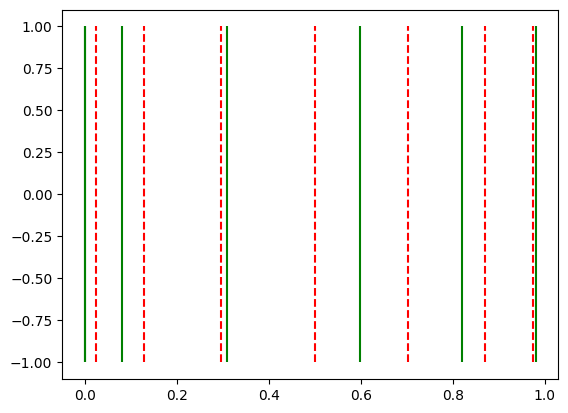

In [24]:
plt.figure()
plt.vlines(x = x_cheb, ymin=-1, ymax=1, colors = 'green',)
x_gl,_ = I.translate(np.polynomial.legendre.leggauss(rank))
plt.vlines(x = x_gl, ymin=-1, ymax=1, colors = 'red', linestyles=["dashed"])
print(np.around(x_gl,3))
print(np.around(x_cheb,7))